In [1]:
# train_model.py

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os



KEY CORRECTIONS APPLIED:
1. RobustCNN Class: Replaced SimpleCNN with a more robust architecture.
    - nn.BatchNorm2d/1d: Added Batch Normalization for faster, more stable training.
    - nn.AdaptiveAvgPool2d: Replaced the hardcoded flatten size, making the model
      flexible to minor variations in input image size.
    - nn.Sequential: Organized layers into logical blocks for better readability.
2. Device Handling: Added logic to automatically use a GPU (cuda) if available,
    falling back to CPU. This is critical for performance.
3. Model Exportation: Added code to save the trained model's state_dict, which
    is the standard practice for deploying models.
4. Code Structure: Encapsulated the main execution logic in an `if __name__ == "__main__":`
    block, a Python best practice.

In [2]:
# --- Configuration ---
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
MODEL_SAVE_DIR = "models"
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "mnist_robust_cnn.pth")

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class RobustCNN(nn.Module):
    """
    A more robust CNN architecture for MNIST classification.
    """
    def __init__(self):
        super(RobustCNN, self).__init__()
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Adaptive pooling allows flexibility in input size before the classifier
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5), # Increased dropout for better regularization
            nn.Linear(128, 10) # 10 classes for digits 0-9
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

Using device: cpu


In [3]:
def get_data_loaders(batch_size):
    """Prepares and returns the MNIST DataLoaders."""
    # MNIST-specific normalization values
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    return train_loader, test_loader

In [4]:
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    """Trains the model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # Move data to the selected device
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

In [6]:
def test_model(model, device, test_loader, criterion):
    """Evaluates the model on the test set."""
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) # Move data to the selected device
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return all_preds, all_targets

def analyze_and_visualize(all_targets, all_preds):
    """Generates and displays the confusion matrix and classification report."""
    print("--- Model Performance Analysis ---")
    
    # Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)]))
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

--- Starting Training ---
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.364708
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.211227
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.076879
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.102313
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.032502
Epoch 1 Summary: Train Acc: 96.46%, Avg Loss: 0.1478
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.072171
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.019164
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.041209
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.194501
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.105039
Epoch 2 Summary: Train Acc: 98.26%, Avg Loss: 0.0594
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.017501
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.030730
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.058068
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.065489
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.044423
Epoch 3 Summary: Train Acc: 98.73%, Avg Loss: 0.0429
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.010850
Train Epoch: 4 [12800/60000 (21%)]	

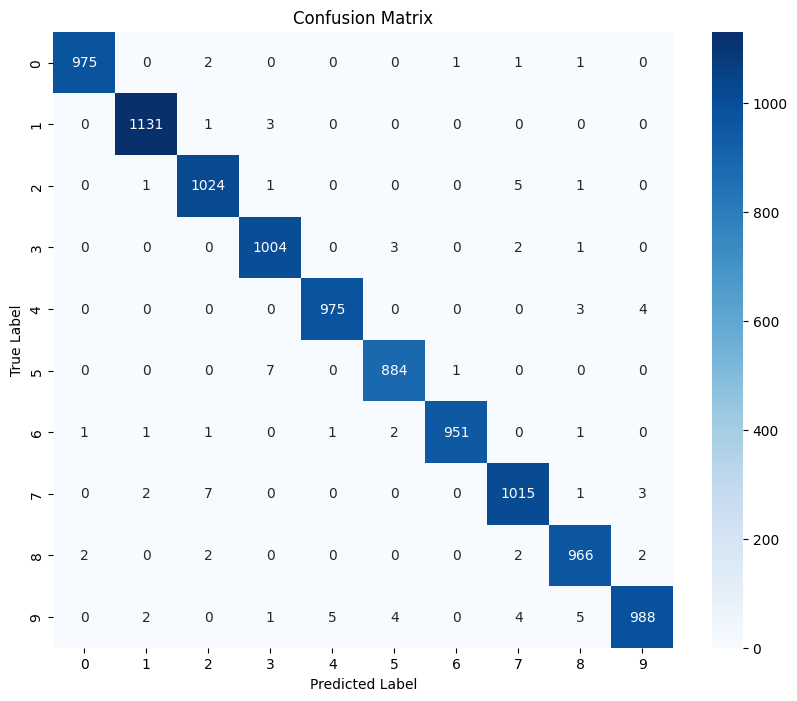

In [7]:
if __name__ == "__main__":
    # 1. Load Data
    train_loader, test_loader = get_data_loaders(BATCH_SIZE)
    
    # 2. Initialize Model, Loss, and Optimizer
    model = RobustCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # 3. Training Loop
    print("--- Starting Training ---")
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, device, train_loader, optimizer, criterion, epoch)
        print(f"Epoch {epoch} Summary: Train Acc: {train_acc:.2f}%, Avg Loss: {train_loss:.4f}")
    print("--- Finished Training ---\n")
    
    # 4. Test and Evaluate the final model
    final_preds, final_targets = test_model(model, device, test_loader, criterion)
    
    # 5. Save the trained model for deployment
    print("--- Exporting Model ---")
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"✅ Model successfully saved to: {MODEL_SAVE_PATH}")
    
    # 6. Perform and show final analysis
    analyze_and_visualize(final_targets, final_preds)